In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Configuration ---
# Base directory for all data
base_data_dir = r'D:\.Study\projects\EnergyForecasting\data' # Use r'...' for raw string

# Subdirectory where your new single-file-per-zone weather files are located
# (e.g., weather_dom.csv, weather_pn.csv)
raw_weather_data_dir = os.path.join(base_data_dir, 'raw_weather_data') # This path seems correct based on your info

# Directory to save the FINAL PROCESSED weather file
processed_data_output_dir = os.path.join(base_data_dir, 'processed')

# List of zone abbreviations (UPPERCASE). MUST MATCH your PJM zones from load processing.
# Example: ['DOM', 'PN', 'PEPCO', 'AECO', 'PE']
PJM_ZONES_UPPER = ['DOM', 'PN', 'PEPCO', 'AECO', 'PE'] # !!! UPDATE TO MATCH YOUR LOAD PROCESSING ZONES !!!

# NEW: Map uppercase zone identifiers to lowercase for filenames
# This handles 'PEPCO' -> 'pepco', 'AECO' -> 'aeco' for filenames if needed
# If your filenames are weather_DOM.csv, weather_PN.csv, then this map is simpler.
# Adjust based on your actual weather filenames like "weather_dom.csv"
ZONE_FILENAME_MAP_WEATHER = {
    'DOM': 'dom',
    'PN': 'pn',
    'PEPCO': 'pepco',
    'AECO': 'aeco',
    'PE': 'pe'
}

# Lat/Lon dictionary (Update if your zones or preferred coordinates changed)
zone_coordinates = {
    'DOM': {'lat': 37.54, 'lon': -77.43},
    'PN':  {'lat': 42.13, 'lon': -80.09},
    'PEPCO': {'lat': 38.91, 'lon': -77.04}, # Matched to potential new zone list
    'AECO':  {'lat': 39.36, 'lon': -74.42},  # Matched to potential new zone list
    'PE':  {'lat': 39.95, 'lon': -75.17}
}
# Ensure keys in zone_coordinates match PJM_ZONES_UPPER

# NEW Filename template for your RAW weather data files (now simpler)
# Example: weather_dom.csv, weather_pn.csv
raw_weather_file_prefix = 'weather_' # Common prefix
raw_weather_file_suffix = '.csv'     # Common suffix

# NEW Output filename for the combined PROCESSED weather data (reflects multi-year)
processed_weather_output_filename_MULTIYEAR = 'pjm_hourly_weather_multi_zone_cleaned_2022-2025May.csv'

# Weather columns map (VERIFY KEYS AGAINST YOUR NEW CSVs)
# Keys are the EXACT column names from your weather CSV files (after any header skipping).
selected_weather_columns_map = {
    'temperature_2m (°C)': 'Temp_C',
    'dew_point_2m (°C)': 'DewPoint_C',
    'apparent_temperature (°C)': 'AppTemp_C',
    'precipitation (mm)': 'Precip_mm',
    'weather_code (wmo code)': 'WeatherCode',
    'cloud_cover (%)': 'CloudCover_Percent',
    'wind_speed_10m (km/h)': 'WindSpeed_kmh',
    'shortwave_radiation (W/m²)': 'SolarRad_Wm2',
    'is_day ()': 'IsDay', # Check exact name like 'is_day ()' or 'is_day'
    'sunshine_duration (s)': 'SunshineDur_s', # If available
    'wind_gusts_10m (km/h)': 'WindGust_kmh', # If available
    'snowfall (cm)': 'Snowfall_cm',       # If available
    'snow_depth (m)': 'SnowDepth_m'        # If available
}
# Timestamp column name in the weather CSVs (e.g., 'time' for Open-Meteo)
TIMESTAMP_COL_NAME_WEATHER_CSV = 'time' # !!! VERIFY THIS !!!

# !!! CRITICAL: INSPECT YOUR NEW CSV FILES !!!
# How many rows to skip at the beginning of the CSV?
# If it's a standard CSV with headers on the first line, use 0.
# If Open-Meteo with metadata comments, it might be 2, 3, or 4.
CSV_HEADER_ROW_NUMBER = 2 # Example: for Open-Meteo files. Set to 0 if no metadata rows.

print(f"Raw weather data expected in: {raw_weather_data_dir}")
print(f"Zones to process for weather: {PJM_ZONES_UPPER}")

Raw weather data expected in: D:\.Study\projects\EnergyForecasting\data\raw_weather_data
Zones to process for weather: ['DOM', 'PN', 'PEPCO', 'AECO', 'PE']


In [2]:
def process_single_zone_weather_file(file_path, zone_id_upper, columns_map, ts_col_csv, csv_header_row):
    """
    Loads and processes a single zone's weather CSV file (which contains all years for that zone).
    - Skips metadata header rows based on csv_header_row.
    - Sets datetime index from ts_col_csv (converts to UTC).
    - Selects and renames specified weather columns.
    - Fills missing values.
    """
    print(f"\nProcessing weather file for zone '{zone_id_upper}': {file_path}")
    try:
        # Use csv_header_row from config
        df = pd.read_csv(file_path, header=csv_header_row)
        print(f"  Successfully loaded. Initial shape: {df.shape}")
        
        df.columns = df.columns.str.strip()
        # print(f"  Cleaned columns: {df.columns.tolist()}") # Can be verbose

        # 1. Handle Timestamp column
        if ts_col_csv not in df.columns:
            print(f"  ERROR: Timestamp column '{ts_col_csv}' not found in {file_path}. Available: {df.columns.tolist()}. Skipping.")
            return None
        
        # Assuming Open-Meteo provides timestamps that can be directly interpreted as UTC
        # or are timezone naive and should be localized to UTC.
        # If timestamps already have UTC offset, pd.to_datetime will handle it.
        # If naive, explicitly localize:
        # df[ts_col_csv] = pd.to_datetime(df[ts_col_csv], errors='coerce').dt.tz_localize('UTC', ambiguous='NaT', nonexistent='NaT')
        df[ts_col_csv] = pd.to_datetime(df[ts_col_csv], errors='coerce', utc=True) # Simpler if direct UTC or to be made UTC

        df.dropna(subset=[ts_col_csv], inplace=True)
        if df.empty:
            print(f"  DataFrame empty after dropping NaT timestamps for {zone_id_upper}. Skipping.")
            return None
        df.set_index(ts_col_csv, inplace=True)
        df.sort_index(inplace=True) # Sort after setting index
        print(f"  Set '{ts_col_csv}' as DatetimeIndex (UTC) and sorted.")

        # 2. Select and Rename specified columns
        processed_columns_data = {}
        for original_col_from_map, new_suffix in columns_map.items():
            original_col_key_cleaned = original_col_from_map.strip()
            if original_col_key_cleaned in df.columns:
                new_col_name = f"{zone_id_upper}_{new_suffix}" # Use uppercase zone_id_upper
                processed_columns_data[new_col_name] = df[original_col_key_cleaned].copy()
            else:
                print(f"  WARNING: Column '{original_col_key_cleaned}' (from map) not found in file for zone {zone_id_upper}.")
        
        if not processed_columns_data:
            print(f"  ERROR: No specified weather columns found or processed for zone {zone_id_upper}. Skipping.")
            return None

        zone_weather_df = pd.DataFrame(processed_columns_data)
        print(f"  Selected and renamed columns. Shape: {zone_weather_df.shape}")

        # 3. Handle Missing Values
        missing_before = zone_weather_df.isnull().sum().sum()
        if missing_before > 0:
            print(f"  Missing values before fill for {zone_id_upper}: {missing_before}")
        
        zone_weather_df = zone_weather_df.ffill().bfill()
        
        missing_after = zone_weather_df.isnull().sum().sum()
        if missing_after > 0:
             print(f"  Missing values AFTER fill for {zone_id_upper}: {missing_after}")
        elif missing_before > 0:
             print(f"  All missing values filled for {zone_id_upper}.")


        if zone_weather_df.isnull().all().any():
            print(f"  ERROR: One or more columns in zone {zone_id_upper} are entirely NaN after processing.")
            return None
            
        return zone_weather_df

    except FileNotFoundError:
        print(f"  ERROR: Weather file not found at {file_path}.")
        return None
    except Exception as e:
        print(f"  ERROR: An unexpected error occurred while processing {file_path} for zone {zone_id_upper}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

--- Attempting to process test file: D:\.Study\projects\EnergyForecasting\data\raw_weather_data\weather_dom.csv ---

Processing weather file for zone 'DOM': D:\.Study\projects\EnergyForecasting\data\raw_weather_data\weather_dom.csv
  Successfully loaded. Initial shape: (29928, 12)
  Set 'time' as DatetimeIndex (UTC) and sorted.
  Selected and renamed columns. Shape: (29928, 11)
  Missing values before fill for DOM: 230
  All missing values filled for DOM.

--- Processed DOM Weather Data (Sample) ---
                           DOM_Temp_C  DOM_DewPoint_C  DOM_AppTemp_C  \
time                                                                   
2022-01-01 00:00:00+00:00       -10.6           -15.0          -15.1   
2022-01-01 01:00:00+00:00       -11.1           -15.2          -15.6   
2022-01-01 02:00:00+00:00       -10.1           -14.5          -14.1   
2022-01-01 03:00:00+00:00       -11.0           -14.8          -15.4   
2022-01-01 04:00:00+00:00        -8.5           -14.4          

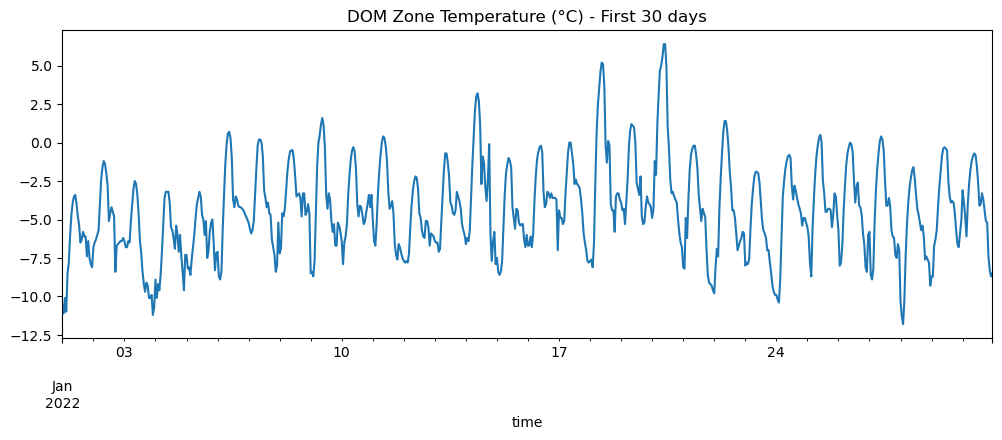

In [3]:
# --- Test processing for a single zone (e.g., DOM) ---
# Ensure PJM_ZONES_UPPER and ZONE_FILENAME_MAP_WEATHER are defined in Cell 1
if PJM_ZONES_UPPER:
    test_zone_id_weather_upper = PJM_ZONES_UPPER[0] # e.g., 'DOM'
    test_zone_filename_lower = ZONE_FILENAME_MAP_WEATHER.get(test_zone_id_weather_upper)

    if test_zone_filename_lower:
        # Construct filename e.g. weather_dom.csv
        test_weather_file_name = f"{raw_weather_file_prefix}{test_zone_filename_lower}{raw_weather_file_suffix}"
        test_weather_file_path = os.path.join(raw_weather_data_dir, test_weather_file_name)

        print(f"--- Attempting to process test file: {test_weather_file_path} ---")
        if not os.path.exists(raw_weather_data_dir):
            os.makedirs(raw_weather_data_dir)
            print(f"Created directory: {raw_weather_data_dir}")
        
        if os.path.exists(test_weather_file_path):
            single_zone_processed_weather_df = process_single_zone_weather_file(
                file_path=test_weather_file_path,
                zone_id_upper=test_zone_id_weather_upper, # Pass uppercase zone ID
                columns_map=selected_weather_columns_map,
                ts_col_csv=TIMESTAMP_COL_NAME_WEATHER_CSV,
                csv_header_row=CSV_HEADER_ROW_NUMBER
            )

            if single_zone_processed_weather_df is not None and not single_zone_processed_weather_df.empty:
                print(f"\n--- Processed {test_zone_id_weather_upper} Weather Data (Sample) ---")
                print(single_zone_processed_weather_df.head())
                print(f"\nInfo for {test_zone_id_weather_upper} Weather Data:")
                single_zone_processed_weather_df.info()
                
                # Plotting (optional, keep if useful)
                temp_col_to_plot = f'{test_zone_id_weather_upper}_Temp_C'
                if temp_col_to_plot in single_zone_processed_weather_df.columns:
                     single_zone_processed_weather_df[temp_col_to_plot].iloc[:24*30].plot(figsize=(12,4)) # Plot first 30 days
                     plt.title(f'{test_zone_id_weather_upper} Zone Temperature (°C) - First 30 days')
                     plt.show()
            else:
                print(f"Processing failed or returned empty DataFrame for {test_zone_id_weather_upper}.")
        else:
            print(f"WEATHER TEST FILE NOT FOUND: {test_weather_file_path}")
            print(f"Please ensure you have downloaded it and placed it in '{raw_weather_data_dir}'.")
    else:
        print(f"Filename mapping not found for test zone: {test_zone_id_weather_upper}")
else:
    print("PJM_ZONES_UPPER is not defined or empty. Cannot run test.")

In [4]:
all_processed_weather_dfs_multiyear = [] # Renamed for clarity

print("\n--- Starting Processing of All Zone Weather Files (Multi-Year in Single File per Zone) ---")

for zone_id_upper_main in PJM_ZONES_UPPER: # e.g., 'DOM', 'PEPCO'
    zone_filename_lower_main = ZONE_FILENAME_MAP_WEATHER.get(zone_id_upper_main)
    
    if not zone_filename_lower_main:
        print(f"  Skipping zone {zone_id_upper_main} due to missing filename map entry.")
        continue

    # Construct filename, e.g., weather_dom.csv
    current_weather_file_name = f"{raw_weather_file_prefix}{zone_filename_lower_main}{raw_weather_file_suffix}"
    current_weather_file_path = os.path.join(raw_weather_data_dir, current_weather_file_name)
    
    if os.path.exists(current_weather_file_path):
        processed_df_zone = process_single_zone_weather_file(
            file_path=current_weather_file_path,
            zone_id_upper=zone_id_upper_main, # Pass uppercase
            columns_map=selected_weather_columns_map,
            ts_col_csv=TIMESTAMP_COL_NAME_WEATHER_CSV,
            csv_header_row=CSV_HEADER_ROW_NUMBER
        )
        
        if processed_df_zone is not None and not processed_df_zone.empty:
            all_processed_weather_dfs_multiyear.append(processed_df_zone)
            print(f"  Successfully processed weather data for zone {zone_id_upper_main}.")
        else:
            print(f"  Skipping zone {zone_id_upper_main} for weather data combination due to processing errors or empty result.")
    else:
        print(f"  Weather file not found for zone {zone_id_upper_main}: {current_weather_file_path}. Skipping.")

print("\n--- Finished processing individual zone weather files ---")

# --- Combining all processed zone weather DataFrames ---
combined_weather_df_final = pd.DataFrame() # Renamed for clarity

if all_processed_weather_dfs_multiyear:
    print(f"Successfully processed {len(all_processed_weather_dfs_multiyear)} zone weather files.")
    combined_weather_df_final = all_processed_weather_dfs_multiyear[0].copy()
    
    if len(all_processed_weather_dfs_multiyear) > 1:
        for i in range(1, len(all_processed_weather_dfs_multiyear)):
            next_df = all_processed_weather_dfs_multiyear[i]
            if not next_df.empty:
                print(f"Merging with weather DataFrame for zone: {next_df.columns[0].split('_')[0]}") # Extracts zone from col name
                combined_weather_df_final = pd.merge(
                    combined_weather_df_final, next_df,
                    left_index=True, right_index=True, how='outer'
                )
            else:
                print(f"Skipping an empty weather DataFrame at index {i} during merge.")
    
    if not combined_weather_df_final.empty:
        print("Successfully merged all zone weather DataFrames.")
        print("\nCombined Weather DataFrame (first 3 rows):")
        print(combined_weather_df_final.head(3))
        print("\nCombined Weather DataFrame (last 3 rows):")
        print(combined_weather_df_final.tail(3))
        print("\nInformation about Combined Weather DataFrame:")
        combined_weather_df_final.info()

        missing_before_final_fill = combined_weather_df_final.isnull().sum().sum()
        if missing_before_final_fill > 0:
            print(f"\nMissing values in combined_weather_df before final fill: {missing_before_final_fill}")
        
        combined_weather_df_final = combined_weather_df_final.ffill().bfill()
        
        missing_after_final_fill = combined_weather_df_final.isnull().sum().sum()
        if missing_after_final_fill > 0:
            print(f"Missing values in combined_weather_df AFTER final combined fill: {missing_after_final_fill}")
        elif missing_before_final_fill > 0 :
            print("All missing values in combined_weather_df filled.")


        if combined_weather_df_final.isnull().all().any():
            print("WARNING: One or more columns in the final combined weather DataFrame are entirely NaN!")
        
        combined_weather_df_final.sort_index(inplace=True) # Sort after all merges and fills

        if combined_weather_df_final.index.has_duplicates:
            print("\nWARNING: The final combined_weather_df has DUPLICATE TIMESTAMPS in its index!")
            # This should ideally not happen if individual zone files have unique, sorted timestamps.
            # If it does, you might need to investigate why or add a step to resolve them:
            # combined_weather_df_final = combined_weather_df_final[~combined_weather_df_final.index.duplicated(keep='first')]
            # print("  Duplicates removed by keeping the first occurrence.")
        else:
            print("\nConfirmed: The final combined_weather_df has a unique DatetimeIndex.")
    else:
        print("Combined weather DataFrame is empty after merging attempts.")
else:
    print("No zone weather DataFrames were successfully processed. Cannot combine.")


--- Starting Processing of All Zone Weather Files (Multi-Year in Single File per Zone) ---

Processing weather file for zone 'DOM': D:\.Study\projects\EnergyForecasting\data\raw_weather_data\weather_dom.csv
  Successfully loaded. Initial shape: (29928, 12)
  Set 'time' as DatetimeIndex (UTC) and sorted.
  Selected and renamed columns. Shape: (29928, 11)
  Missing values before fill for DOM: 230
  All missing values filled for DOM.
  Successfully processed weather data for zone DOM.

Processing weather file for zone 'PN': D:\.Study\projects\EnergyForecasting\data\raw_weather_data\weather_pn.csv
  Successfully loaded. Initial shape: (29928, 12)
  Set 'time' as DatetimeIndex (UTC) and sorted.
  Selected and renamed columns. Shape: (29928, 11)
  Missing values before fill for PN: 230
  All missing values filled for PN.
  Successfully processed weather data for zone PN.

Processing weather file for zone 'PEPCO': D:\.Study\projects\EnergyForecasting\data\raw_weather_data\weather_pepco.csv
 

In [5]:
if not combined_weather_df_final.empty:
    if not os.path.exists(processed_data_output_dir):
        os.makedirs(processed_data_output_dir)
        print(f"Created directory: {processed_data_output_dir}")

    # Use the new multi-year output filename from Cell 1
    final_weather_output_path = os.path.join(processed_data_output_dir, processed_weather_output_filename_MULTIYEAR)
    
    combined_weather_df_final.to_csv(final_weather_output_path)
    print(f"\nProcessed and combined multi-year weather data saved to: {final_weather_output_path}")
else:
    print("\nCombined weather DataFrame is empty. Nothing to save.")


Processed and combined multi-year weather data saved to: D:\.Study\projects\EnergyForecasting\data\processed\pjm_hourly_weather_multi_zone_cleaned_2022-2025May.csv



--- Plotting Sample of Combined Multi-Year Weather Data ---


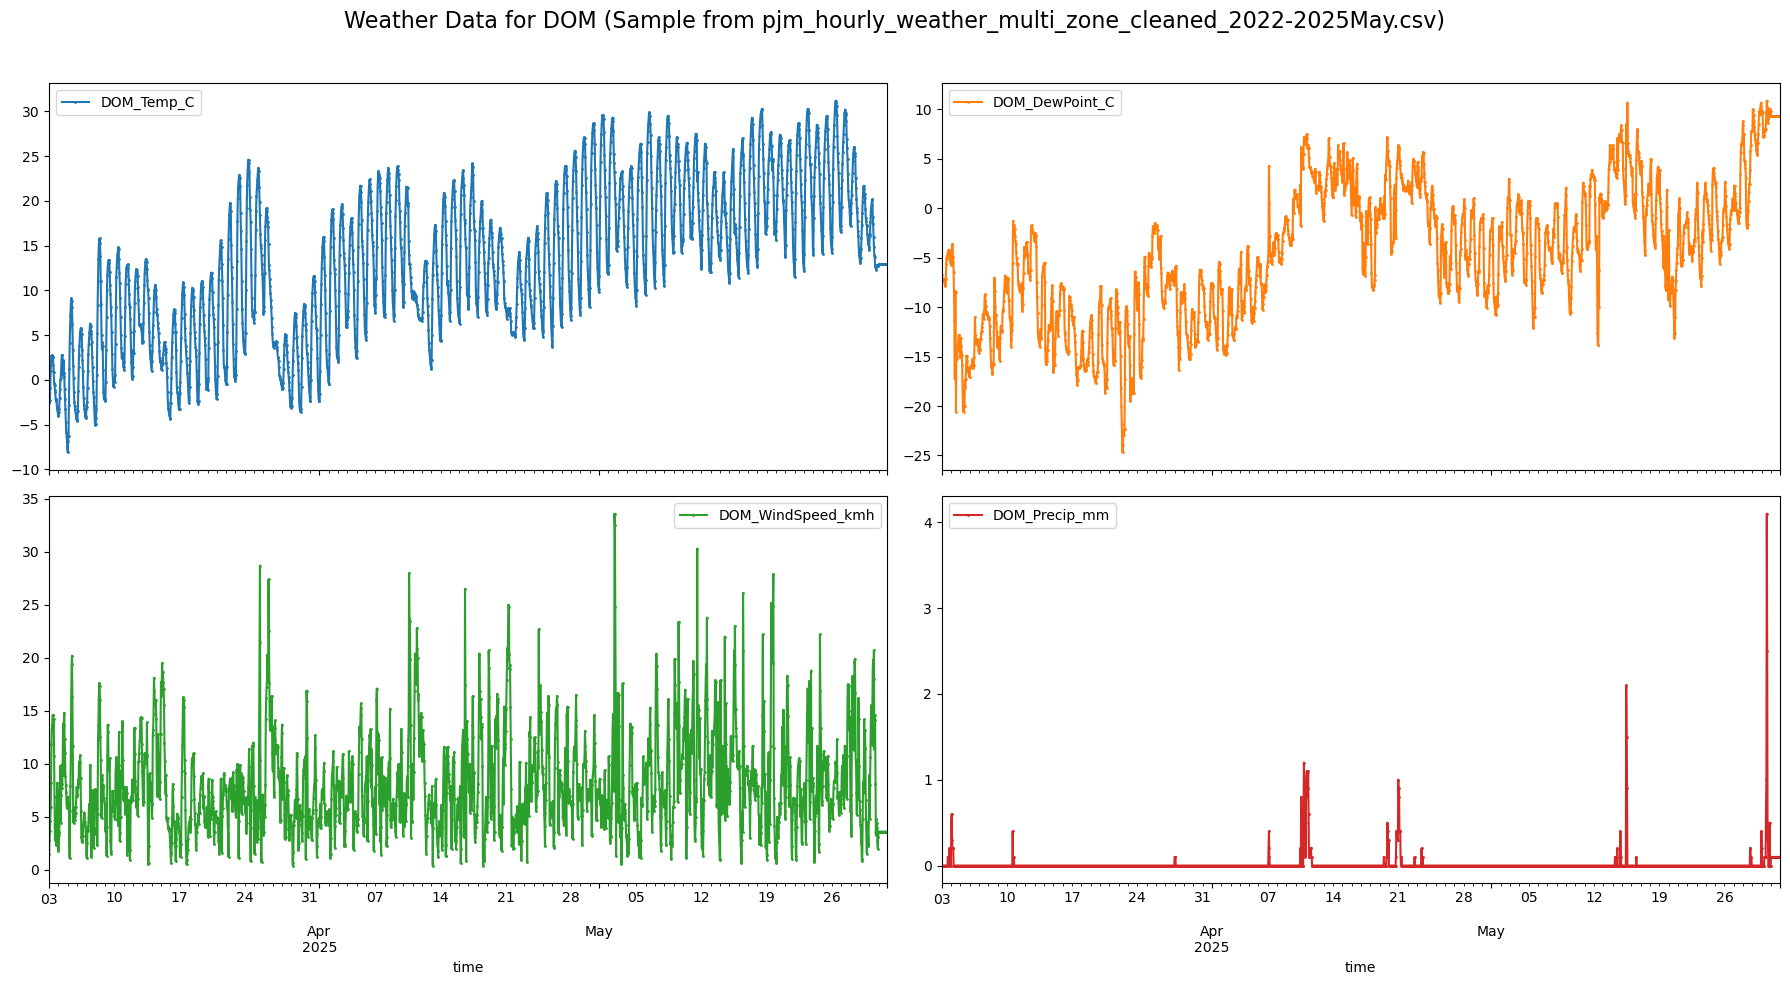

In [7]:
# Cell 6: Plotting (CORRECTED)

if not combined_weather_df_final.empty: # MODIFIED: Was combined_weather_df
    print("\n--- Plotting Sample of Combined Multi-Year Weather Data ---")
    
    if PJM_ZONES_UPPER: # Ensure list is not empty
        zone_to_plot_weather = PJM_ZONES_UPPER[0] # Plot for the first zone in the list
        cols_to_plot = [
            f'{zone_to_plot_weather}_Temp_C',
            f'{zone_to_plot_weather}_DewPoint_C', # If available and selected
            f'{zone_to_plot_weather}_WindSpeed_kmh', # If available
            f'{zone_to_plot_weather}_Precip_mm' # If available
        ]
        
        # Use the final DataFrame name here as well
        plottable_cols = [col for col in cols_to_plot if col in combined_weather_df_final.columns] # MODIFIED
        
        if plottable_cols:
            # Plot a recent period, e.g., last 90 days, to keep plot readable
            days_to_plot_sample = 90
            # Use the final DataFrame name here as well
            if len(combined_weather_df_final) >= 24 * days_to_plot_sample: # MODIFIED
                data_subset_to_plot = combined_weather_df_final[plottable_cols].iloc[-24*days_to_plot_sample:] # MODIFIED
            else: # Plot all if less than 90 days of data
                data_subset_to_plot = combined_weather_df_final[plottable_cols] # MODIFIED

            if not data_subset_to_plot.empty:
                data_subset_to_plot.plot(figsize=(18, 10), subplots=True, layout=(-1, 2), sharex=True, marker='.', markersize=2, linestyle='-')
                plt.suptitle(f'Weather Data for {zone_to_plot_weather} (Sample from {processed_weather_output_filename_MULTIYEAR})', fontsize=16)
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()
            else:
                print(f"No data to plot for selected columns for zone {zone_to_plot_weather}.")
        else:
            # Use the final DataFrame name here as well
            print(f"Could not find specified columns for plotting for zone {zone_to_plot_weather}. Available: {combined_weather_df_final.columns.to_list()[:10]}...") # MODIFIED
    else:
        print("PJM_ZONES_UPPER list is empty, cannot select a zone for plotting.")
else:
    # Use the final DataFrame name here as well
    print("Cannot plot, combined_weather_df_final is empty.") # MODIFIED